# Save desired images and groundtruth masks

In [2]:
import sys

%load_ext autoreload
%autoreload 2
      
sys.path.append('../')

import torch
from dataset import data_loaders, BrainSegmentationDataset
from utils import postprocess_per_volume, dsc_distribution, plot_dsc, gray2rgb, outline
from skimage.io import imsave, imshow
import numpy as np
from matplotlib import pyplot as plt

from models.unet import UNet

In [3]:
device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0")

batch_size = 16
epochs = 50
lr = 0.0001
workers = 2
weights = "./"
image_size = 224
aug_scale = 0.05
aug_angle = 15

_, loader_valid = data_loaders(batch_size, workers, image_size, aug_scale, aug_angle, path="../kaggle_3m", valid_only=True)

reading validation images...
preprocessing validation volumes...
cropping validation volumes...
padding validation volumes...
resizing validation volumes...
normalizing validation volumes...
done creating validation dataset


In [4]:

unet = UNet(in_channels=BrainSegmentationDataset.in_channels, out_channels=BrainSegmentationDataset.out_channels)
state_dict = torch.load('../weights/unet.pt', map_location=device)
unet.load_state_dict(state_dict)
unet.eval()
unet.to(device)

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [5]:

input_list = []
pred_list = []
true_list = []

for i, data in enumerate(loader_valid):
    x, y_true = data
    x, y_true = x.to(device), y_true.to(device)
    
    with torch.set_grad_enabled(False):
        y_pred = unet(x)
        y_pred_np = y_pred.detach().cpu().numpy()
        pred_list.extend([y_pred_np[s] for s in range(y_pred_np.shape[0])])
        y_true_np = y_true.detach().cpu().numpy()
        true_list.extend([y_true_np[s] for s in range(y_true_np.shape[0])])
        x_np = x.detach().cpu().numpy()
        input_list.extend([x_np[s] for s in range(x_np.shape[0])])


In [6]:
volumes = postprocess_per_volume(
        input_list,
        pred_list,
        true_list,
        loader_valid.dataset.patient_slice_index,
        loader_valid.dataset.patients,
    )

In [7]:
print(f"{volumes.keys() = }")
print(f"{volumes['TCGA_HT_7616_19940813'][0].shape = }")
print(f"{volumes['TCGA_HT_7616_19940813'][1].shape = }")
print(f"{volumes['TCGA_HT_7616_19940813'][2].shape = }")

volumes.keys() = dict_keys(['TCGA_HT_7616_19940813', 'TCGA_CS_6668_20011025', 'TCGA_CS_4944_20010208', 'TCGA_HT_7879_19981009', 'TCGA_DU_7014_19860618', 'TCGA_DU_6408_19860521', 'TCGA_DU_6404_19850629', 'TCGA_DU_5851_19950428', 'TCGA_CS_6667_20011105', 'TCGA_HT_7692_19960724'])
volumes['TCGA_HT_7616_19940813'][0].shape = (28, 3, 224, 224)
volumes['TCGA_HT_7616_19940813'][1].shape = (28, 1, 224, 224)
volumes['TCGA_HT_7616_19940813'][2].shape = (28, 1, 224, 224)


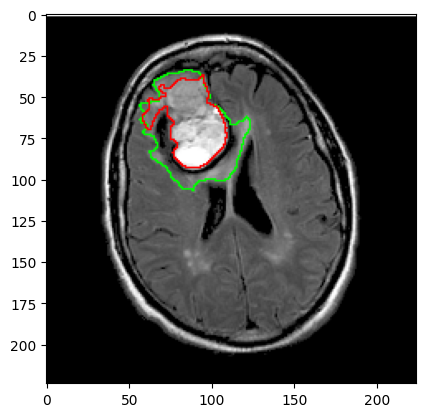

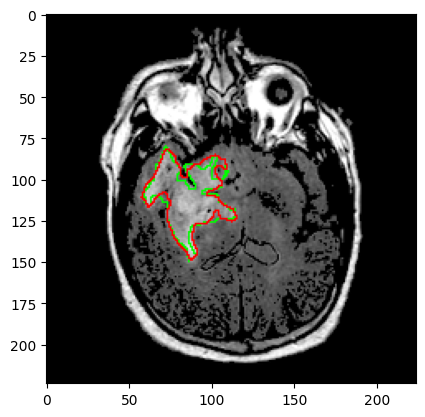

In [31]:
selected_patient = ['TCGA_HT_7616_19940813', 'TCGA_DU_7014_19860618']
selected_idx = [17, 28]

for patient, idx in zip(selected_patient, selected_idx):
    x = volumes[patient][0][idx]
    y_pred = volumes[patient][1][idx]
    y_true = volumes[patient][2][idx]
    
    image = gray2rgb(x[1])  # channel 1 is for FLAIR
    imsave(f'../images/model_comp_{patient}_x.png', image)
    
    image = outline(image, y_true[0]/255, color=[0, 255, 0])
    
    imsave(f'../images/model_comp_{patient}_y_true.png', image)

    image = outline(image, y_pred[0], color=[255, 0, 0])

    imsave(f'../images/model_comp_{patient}_unet.png', image)

    plt.figure()
    plt.imshow(image)

    # break


In [ ]:

import cv2

# Load the image
image = cv2.imread('TCGA_HT_7616_19940813_19_mask.tif', cv2.IMREAD_UNCHANGED)

# Save the image as PNG
cv2.imwrite('TCGA_HT_7616_19940813_19_mask.png', image)